In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os



In [40]:
PATH_TRAIN = 'data'
PATH_TEST = 'test'
k = 3

In [41]:

# Fungsi untuk membaca dan memproses satu gambar
def process_image(image_path, image_size=(75, 75)):
    image = cv2.imread(image_path)
    if image is None:
        return None
    # Resize gambar
    image = cv2.resize(image, image_size)
    # Convert BGR ke RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Reshape menjadi 2D array (1 baris per pixel, 3 kolom untuk channel RGB)
    pixels = image.reshape(-1, 3)
    return pixels

# Path ke folder data
folder_path = PATH_TRAIN

# List untuk menyimpan semua pixel dari semua gambar
all_pixels = []

# Loop melalui semua file gambar di folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Filter untuk file gambar
        image_path = os.path.join(folder_path, filename)
        pixels = process_image(image_path)
        if pixels is not None:
            all_pixels.append(pixels)

# Gabungkan semua pixel dari gambar-gambar menjadi satu array 2D
all_pixels = np.vstack(all_pixels)
pixels = all_pixels
# Output jumlah pixel total
print(f"Total jumlah pixel: {all_pixels.shape[0]}")


Total jumlah pixel: 39375


In [42]:
import numpy as np

def euclidean_distance(point1, point2):
    """Hitung jarak Euclidean antara dua titik."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def kmeans_manual(features, k, centroids, max_iters=100):
    for it in range(max_iters):
        # 2. Assign cluster
        labels = np.zeros(features.shape[0])
        for i in range(features.shape[0]):
            distances = np.array([euclidean_distance(features[i], centroid) for centroid in centroids])
            labels[i] = np.argmin(distances)  
        # 3. Update centroid
        new_centroids = np.zeros(centroids.shape)
        for j in range(k):
            if np.any(labels == j):  
                new_centroids[j] = features[labels == j].mean(axis=0)
        print(it)
        # 4. Periksa konvergensi (jika centroid tidak berubah)
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids
    return centroids

In [43]:

def initialize_centroids(data, k):
    """
    Memilih centroid awal untuk KMeans menggunakan metode KMeans++.

    Parameters:
    data : array-like, shape (n_samples, n_features)
        Data input.
    k : int
        Jumlah cluster.

    Returns:
    centroids : array, shape (k, n_features)
        Centroid awal untuk KMeans.
    """
    # Inisialisasi list untuk centroid
    centroids = []
    
    # Pilih centroid pertama secara acak dari data
    centroids.append(data[np.random.randint(0, len(data))])
    
    # Pilih centroid lainnya menggunakan probabilitas jarak
    for _ in range(1, k):
        # Hitung jarak terdekat dari tiap data point ke centroid yang sudah ada
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in data])
        
        # Hitung probabilitas untuk memilih setiap data point sebagai centroid berikutnya
        probabilities = distances / distances.sum()
        
        # Pilih data point baru berdasarkan probabilitas
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        next_centroid_index = np.searchsorted(cumulative_probabilities, r)
        centroids.append(data[next_centroid_index])
    
    return np.array(centroids)


In [44]:

stcentroid = initialize_centroids(pixels, k)
# stcentroid = initialize_centroids_kmeans_pp(pixels,k)
centroids = kmeans_manual(pixels,k,stcentroid)

# Buat gambar baru berdasarkan label cluster
# clustered_image = labels.reshape(image.shape[:2])
centroids



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


array([[206.50193153, 205.75849207, 201.20447582],
       [119.31633687, 119.32437361, 104.04646451],
       [ 44.53941738,  55.3251861 ,  41.62083114]])

mountain_314.jpg


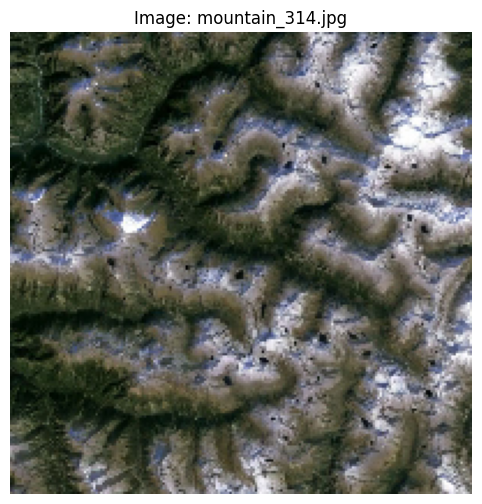

mountain_315.jpg


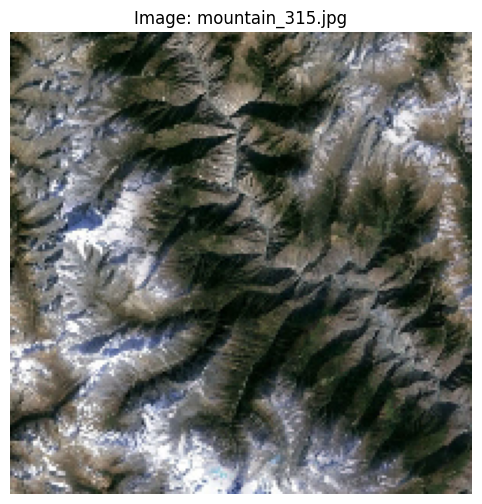

mountain_316.jpg


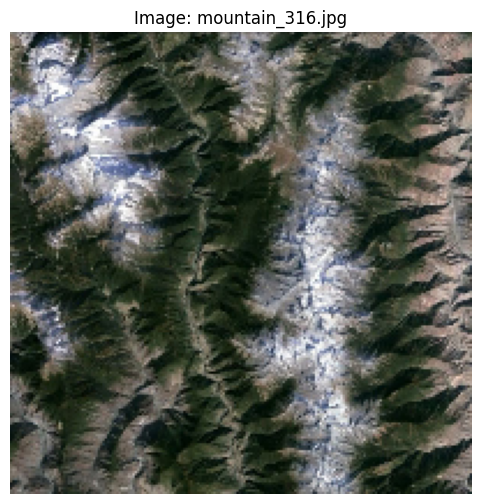

Total images loaded: 3


In [45]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Folder yang berisi gambar
folder_path = PATH_TEST  # Ganti dengan path folder Anda

# List untuk menyimpan semua pixels dan gambar
all_images = []
all_pixels = []

# Tampilkan gambar asli
def show_image(image, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Menelusuri semua file dalam folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Menghitung hanya file gambar
        # Membaca gambar
        print(filename)
        image = cv2.imread(os.path.join(folder_path, filename))

        # Cek apakah gambar berhasil dibaca
        if image is None:
            print(f"Gagal membaca gambar: {filename}")
            continue

        # Resize gambar ke 200x200
        image = cv2.resize(image, (200, 200))

        # Convert BGR ke RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Ubah gambar menjadi array pixel 2D
        pixels = image.reshape(-1, 3)  # Bentuknya jadi (n_samples, 3)

        # Menambahkan pixels dan gambar ke list
        all_images.append(image)
        all_pixels.append(pixels)

        # Tampilkan gambar
        show_image(image, f'Image: {filename}')

# Tampilkan jumlah gambar yang dimuat
print(f"Total images loaded: {len(all_images)}")


In [46]:
import numpy as np

def predict_clustering(pixels, centroids, normalize=True):
    """
    Melakukan prediksi cluster untuk setiap data point (pixels) berdasarkan centroid yang sudah ada.

    Parameters:
    pixels : array-like, shape (n_samples, 3)
        Data input yang akan diklasifikasikan ke cluster (RGB values of pixels).
    centroids : array-like, shape (n_clusters, 3)
        Centroid dari setiap cluster (RGB values).
    normalize : bool, default=True
        Jika True, maka nilai RGB akan dinormalisasi menjadi rentang [0, 1].

    Returns:
    labels : array, shape (n_samples,)
        Label cluster untuk setiap pixel.
    """
    # Normalisasi nilai RGB ke [0, 1] jika diperlukan
    if normalize:
        pixels = pixels / 255.0
        centroids = centroids / 255.0

    # Hitung jarak dari setiap pixel ke setiap centroid
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
    
    # Tentukan cluster dengan jarak terdekat untuk setiap pixel
    labels = np.argmin(distances, axis=1)
    
    return labels


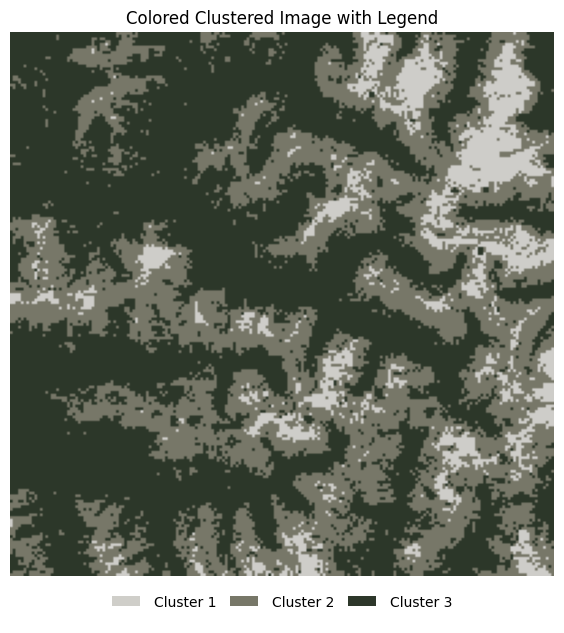

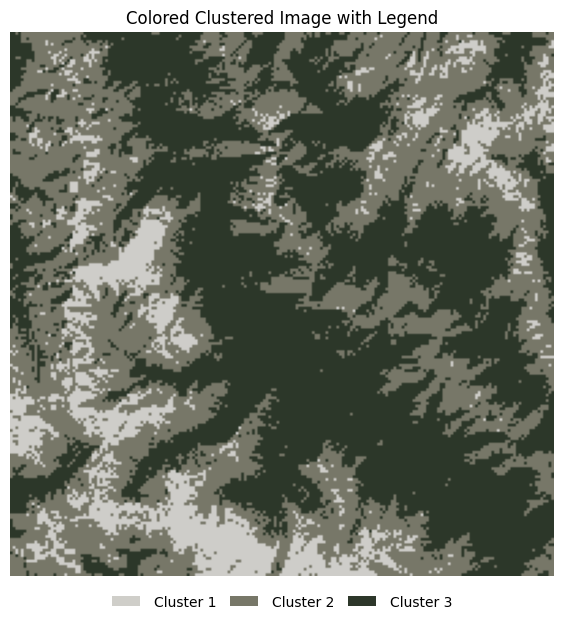

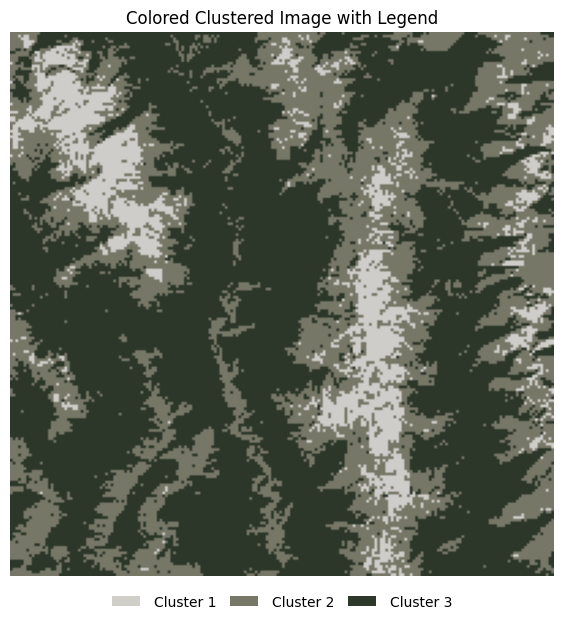

[array([2, 2, 2, ..., 0, 0, 1], dtype=int64),
 array([2, 2, 1, ..., 2, 1, 1], dtype=int64),
 array([1, 1, 1, ..., 1, 2, 2], dtype=int64)]

In [47]:
def visualize_clusters(image, labels, k, centroids):
    """
    Membuat gambar baru berdasarkan hasil cluster, mewarnai piksel sesuai dengan warna dominan dari centroid.

    Parameters:
    image : array-like, shape (height, width, 3)
        Gambar input asli (3 channel RGB).
    labels : array-like, shape (n_samples,)
        Label cluster untuk setiap piksel dalam gambar.
    k : int
        Jumlah cluster.
    centroids : array-like, shape (k, 3)
        Centroid (warna dominan) dari setiap cluster (dalam skala 0-255).

    Returns:
    clustered_rgb_image : array-like, shape (height, width, 3)
        Gambar berwarna sesuai dengan hasil clustering.
    """
    # Buat array kosong untuk gambar cluster
    clustered_rgb_image = np.zeros_like(image)

    # Reshape label menjadi ukuran gambar (2D) untuk akses piksel yang lebih mudah
    height, width, _ = image.shape
    labels_reshaped = labels.reshape(height, width)

    # Assign warna dominan ke piksel sesuai label clusternya
    for cluster in range(k):
        # Ambil warna centroid untuk cluster ini
        dominant_color = centroids[cluster]
        # Warnai semua piksel yang masuk ke dalam cluster ini
        clustered_rgb_image[labels_reshaped == cluster] = dominant_color

    return clustered_rgb_image




# Fungsi untuk menampilkan gambar dengan legenda
def show_image_with_legend(image, centroids, k, title):
    plt.figure(figsize=(8, 8))  # Ukuran gambar lebih besar untuk memberi ruang pada legenda
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

    # Buat list untuk memetakan warna centroid ke legenda
    legend_labels = []
    for i in range(k):
        # Buat patch warna untuk setiap cluster
        color_patch = plt.Rectangle((0, 0), 1, 1, fc=centroids[i]/255.0)
        legend_labels.append(color_patch)
    
    # Tambahkan lebih banyak ruang di bawah gambar untuk legenda
    plt.subplots_adjust(bottom=0.2)  # Memberi ruang ekstra di bawah gambar untuk legenda
    
    # Tambahkan legenda di bawah gambar
    plt.legend(legend_labels, [f'Cluster {i+1}' for i in range(k)],
               loc="lower center", ncol=k, bbox_to_anchor=(0.5, -0.1), 
               frameon=False, borderpad=1, handletextpad=1, columnspacing=1)

    plt.show()
labels = []
for i in range(len(all_images)):
    labels.append(predict_clustering(all_pixels[i],centroids))
    colored_clustered_image = visualize_clusters(image, labels[i], k, centroids)
    # show_image(colored_clustered_image, 'Colored Clustered Image')
    # Tampilkan gambar dengan legenda
    show_image_with_legend(colored_clustered_image, centroids, k, 'Colored Clustered Image with Legend')
labels

In [48]:
from sklearn.metrics import silhouette_score
from matplotlib import cm

# Tentukan colormap
for i in range(len(all_images)):
    sil_score = silhouette_score(all_pixels[i], labels[i])

    print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.533
Silhouette Score: 0.557
Silhouette Score: 0.592
